First 5 rows:
   flow_duration  Header_Length  Protocol Type  Duration           Rate  \
0       0.000000           0.00           1.00     64.00      19.481208   
1       0.000000          54.00           6.00     64.00     191.590718   
2       0.028989       23001.95          15.61     79.28  124783.255406   
3       0.000000          53.46           5.94     63.36       3.999280   
4       0.000000           0.00           1.00     64.00      48.982284   

           Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0      19.481208    0.0              0.0              0.0              0.0   
1     191.590718    0.0              0.0              0.0              0.0   
2  124783.255406    0.0              0.0              0.0              0.0   
3       3.999280    0.0              0.0              1.0              0.0   
4      48.982284    0.0              0.0              0.0              0.0   

   ...       Std  Tot size           IAT  Number   Magnitue    Rad

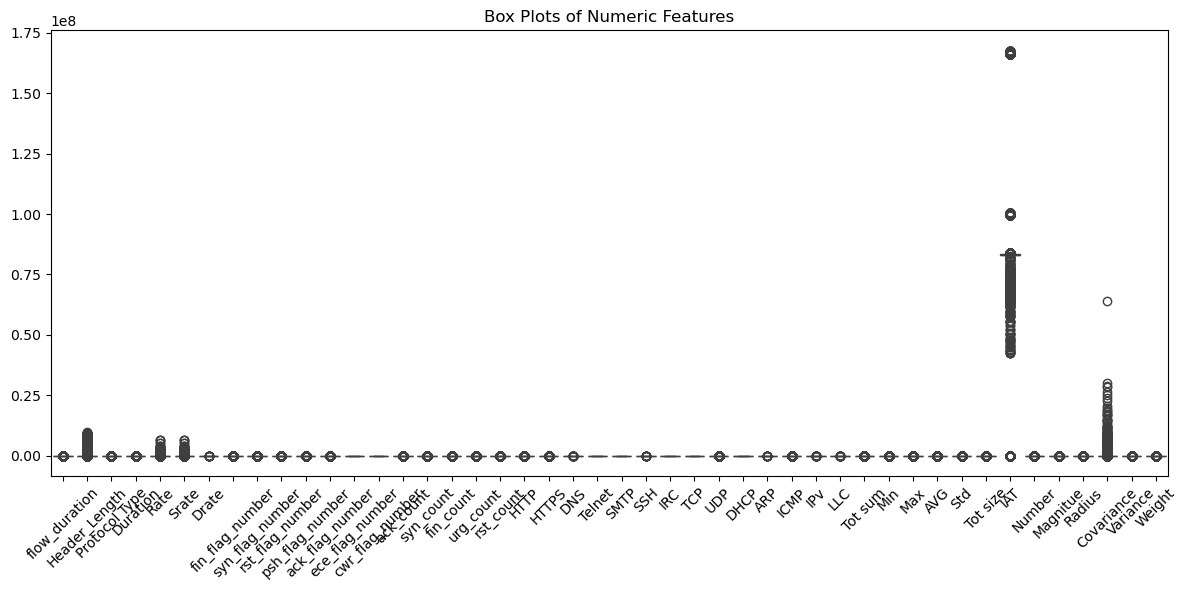

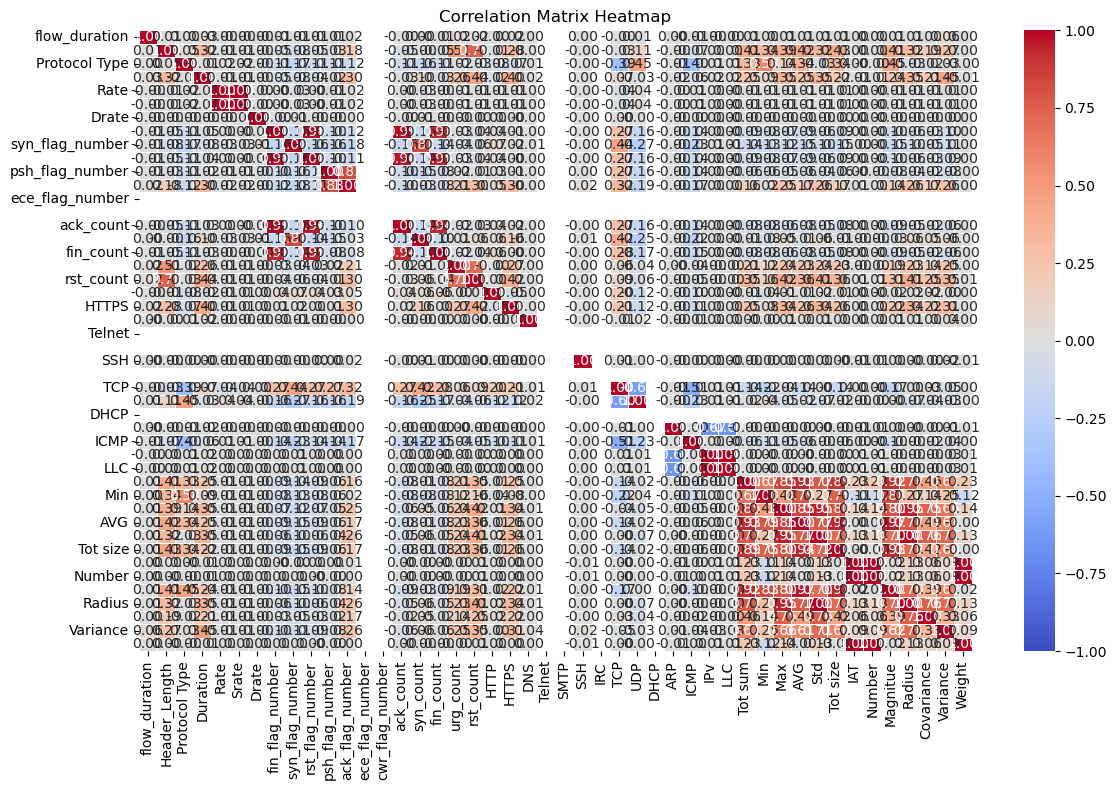

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
# Load dataset
df = pd.read_csv('C:\\ProgramData\\anaconda3\\Lib\\site-packages\\pandas\\io\\parsers\\capstone\\part-00112-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')

# --------------------------
# 1. Data Exploration
# --------------------------
print("First 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

# Visualize numeric features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.title('Box Plots of Numeric Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


In [2]:
# Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())
threshold = 0.3 * len(df)
df_clean = df.dropna(axis=1, thresh=threshold)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(df_clean.drop('label', axis=1)), 
                 columns=df_clean.drop('label', axis=1).columns)
y = df_clean['label']


Missing values before cleaning:
flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
l

In [3]:
# Remove duplicates
X = X.drop_duplicates()
y = y[X.index]


print(f"Rows after preprocessing: {len(X)}")

# --------------------------
# 2. Binary Classification
# --------------------------
print("\n" + "="*50)
print("BINARY CLASSIFICATION")
print("="*50)

# Encode labels
le_binary = LabelEncoder()
y_encoded = le_binary.fit_transform(y)

# Create binary labels (0 = Normal, 1 = Attack)
benign_keywords = ['benign', 'normal', 'legitimate','BenignTraffic']
benign_indices = [i for i, cls in enumerate(le_binary.classes_) 
                 if any(kw in cls.lower() for kw in benign_keywords)]

if benign_indices:
    benign_index = benign_indices[0]
    y_binary = np.where(y_encoded == benign_index, 0, 1)
else:
    # Fallback if no benign class found
    y_binary = np.ones_like(y_encoded)  # Mark all as attacks

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, stratify=y_binary, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify class distribution
unique, counts = np.unique(y_balanced, return_counts=True)
print("\nClass distribution after SMOTE:")
print(f"Normal (0): {counts[0] if 0 in unique else 0}")
print(f"Attack (1): {counts[1] if 1 in unique else 0}")



Rows after preprocessing: 253575

BINARY CLASSIFICATION

Class distribution after SMOTE:
Normal (0): 173385
Attack (1): 173385


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import clone
class BinaryFeatureSelector:
    def __init__(self, X, y, n_features=10, n_iter=50):
        self.X = X
        self.y = y
        self.n_features = min(n_features, X.shape[1])
        self.n_iter = n_iter
        self.best_features = None
        self.best_score = -np.inf
        
    def _calculate_fitness(self, subset):
        if subset.sum() == 0:
            return -np.inf
            
        X_sub = self.X[:, subset.astype(bool)]
        
        # Stratified sampling for evaluation
        X_train, X_val, y_train, y_val = train_test_split(
            X_sub, self.y, test_size=0.2, stratify=self.y, random_state=42
        )
        
        # Lightweight model for evaluation
        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=5,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        return accuracy_score(y_val, model.predict(X_val))
    
    def optimize(self):
        # Initialize with MI-based features
        mi_scores = mutual_info_classif(self.X, self.y)
        top_mi_indices = np.argsort(mi_scores)[-self.n_features:]
        initial_subset = np.zeros(self.X.shape[1])
        initial_subset[top_mi_indices] = 1
        
        self.best_features = initial_subset
        self.best_score = self._calculate_fitness(initial_subset)
        
        # Iterative refinement
        for _ in range(self.n_iter):
            candidate = self.best_features.copy()
            
            # Mutation: flip 10% of features
            flip_mask = np.random.rand(len(candidate)) < 0.1
            candidate = np.logical_xor(candidate, flip_mask).astype(int)
            
            # Ensure we have exactly n_features
            if candidate.sum() > self.n_features:
                # Remove excess features randomly
                on_indices = np.where(candidate)[0]
                np.random.shuffle(on_indices)
                candidate[on_indices[:candidate.sum()-self.n_features]] = 0
            elif candidate.sum() < self.n_features:
                # Add missing features randomly
                off_indices = np.where(candidate == 0)[0]
                np.random.shuffle(off_indices)
                candidate[off_indices[:self.n_features-candidate.sum()]] = 1
                
            score = self._calculate_fitness(candidate)
            
            # Update if improvement
            if score > self.best_score:
                self.best_score = score
                self.best_features = candidate
                
        return self.best_features.astype(bool)
        # 3. Feature Selection
# --------------------------
# Initialize and run feature selector
feature_selector = BinaryFeatureSelector(
    X_balanced, 
    y_balanced,
    n_features=15,  # Optimal number of features
    n_iter=100
)
selected_mask = feature_selector.optimize()

print(f"Selected {selected_mask.sum()} features:")
print(np.where(selected_mask)[0])

# Prepare selected datasets
X_train_selected = X_balanced[:, selected_mask]
X_test_selected = X_test_scaled[:, selected_mask]


Selected 15 features:
[ 6 11 12 13 17 22 27 29 30 33 39 40 42 44 45]




Final Accuracy: 0.993809
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1765
           1       1.00      0.99      1.00     74308

    accuracy                           0.99     76073
   macro avg       0.90      0.99      0.94     76073
weighted avg       0.99      0.99      0.99     76073



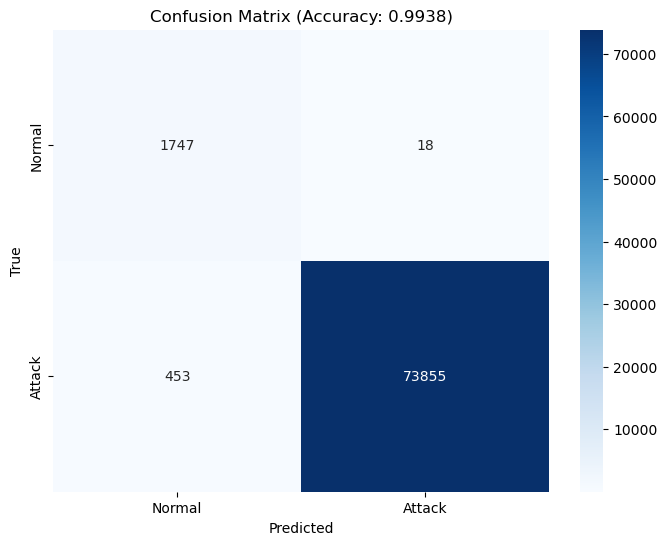

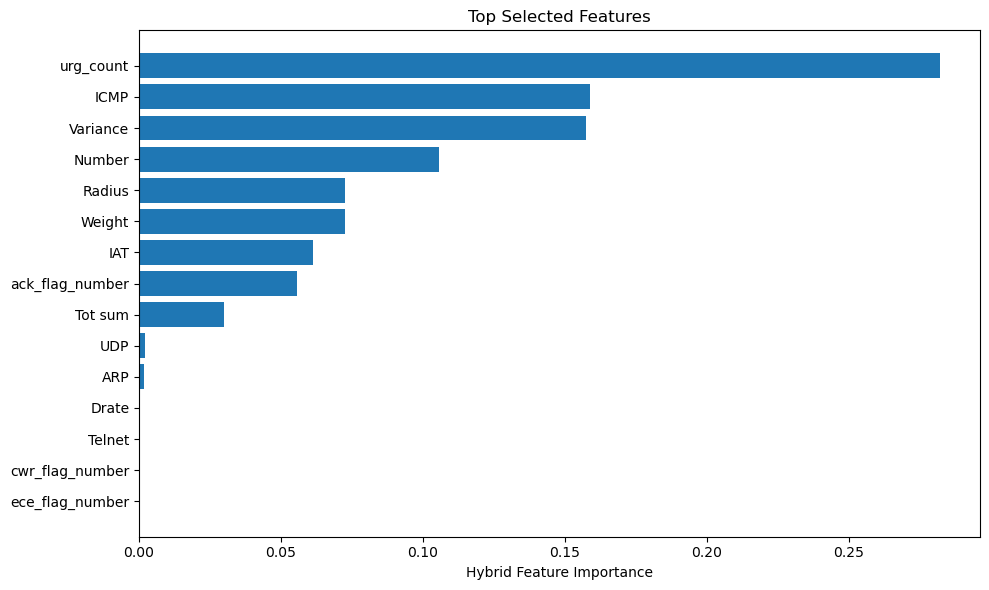

In [5]:

# 4. Hybrid Model Training
# --------------------------
# Optimized base models
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=np.sum(y_balanced == 0) / np.sum(y_balanced == 1),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist'
)

# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf),
        ('xgboost', xgb)
    ],
    final_estimator=LogisticRegression(
        C=0.1,
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Create validation set from balanced training data
X_train_bal, X_val, y_train_bal, y_val = train_test_split(
    X_balanced, y_balanced, 
    test_size=0.2, 
    stratify=y_balanced, 
    random_state=42
)

# Train on training subset
stacking_model.fit(X_train_bal[:, selected_mask], y_train_bal)

# Final evaluation on test set
y_pred = stacking_model.predict(X_test_selected)
final_accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*50)
print(f"\nFinal Accuracy: {final_accuracy:.6f}")
print("="*50)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix and Feature Importance plots remain unchanged
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {final_accuracy:.4f})')
plt.show()
# Feature Importance - Corrected approach
rf = stacking_model.named_estimators_['random_forest']
xgb = stacking_model.named_estimators_['xgboost']

rf_imp = rf.feature_importances_
xgb_imp = xgb.feature_importances_
hybrid_imp = (rf_imp + xgb_imp) / 2

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(hybrid_imp)
plt.barh(range(len(sorted_idx)), hybrid_imp[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[selected_mask][sorted_idx])
plt.xlabel('Hybrid Feature Importance')
plt.title('Top Selected Features')
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
# ... [previous binary classification code] ...
df = pd.read_csv('C:\\ProgramData\\anaconda3\\Lib\\site-packages\\pandas\\io\\parsers\\capstone\\part-00112-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')
# --------------------------
# 3. Multiclass Classification
# --------------------------
print("\n" + "="*50)
print("MULTICLASS CLASSIFICATION")
print("="*50)
# Handle missing values
threshold = 0.3 * len(df)
df_clean = df.dropna(axis=1, thresh=threshold)
# Recreate the imputer for multiclass data
imputer_mc = SimpleImputer(strategy='median')

# Get cleaned data from the original dataset
X_clean = pd.DataFrame(imputer_mc.fit_transform(df_clean.drop('label', axis=1)), 
                      columns=df_clean.drop('label', axis=1).columns)
y_clean = df_clean['label']

# Remove duplicates (same as binary preprocessing)
X_clean = X_clean.drop_duplicates()
y_clean = y_clean[X_clean.index]


# Encode labels
le_multiclass = LabelEncoder()
y_multiclass = le_multiclass.fit_transform(y_clean)

# Split data
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_clean, y_multiclass, test_size=0.3, stratify=y_multiclass, random_state=42
)

# Standardize features
scaler_mc = StandardScaler()
X_train_scaled_mc = scaler_mc.fit_transform(X_train_mc)
X_test_scaled_mc = scaler_mc.transform(X_test_mc)

# Handle class imbalance with SMOTE
smote_mc = SMOTE(random_state=42, k_neighbors=1)
X_balanced_mc, y_balanced_mc = smote_mc.fit_resample(X_train_scaled_mc, y_train_mc)

# Verify class distribution
unique_mc, counts_mc = np.unique(y_balanced_mc, return_counts=True)
print("\nClass distribution after SMOTE:")
for class_idx, count in zip(unique_mc, counts_mc):
    class_name = le_multiclass.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count}")

# Continue with multiclass modeling...



MULTICLASS CLASSIFICATION

Class distribution after SMOTE:
Backdoor_Malware: 27586
BenignTraffic: 27586
BrowserHijacking: 27586
CommandInjection: 27586
DDoS-ACK_Fragmentation: 27586
DDoS-HTTP_Flood: 27586
DDoS-ICMP_Flood: 27586
DDoS-ICMP_Fragmentation: 27586
DDoS-PSHACK_Flood: 27586
DDoS-RSTFINFlood: 27586
DDoS-SYN_Flood: 27586
DDoS-SlowLoris: 27586
DDoS-SynonymousIP_Flood: 27586
DDoS-TCP_Flood: 27586
DDoS-UDP_Flood: 27586
DDoS-UDP_Fragmentation: 27586
DNS_Spoofing: 27586
DictionaryBruteForce: 27586
DoS-HTTP_Flood: 27586
DoS-SYN_Flood: 27586
DoS-TCP_Flood: 27586
DoS-UDP_Flood: 27586
MITM-ArpSpoofing: 27586
Mirai-greeth_flood: 27586
Mirai-greip_flood: 27586
Mirai-udpplain: 27586
Recon-HostDiscovery: 27586
Recon-OSScan: 27586
Recon-PingSweep: 27586
Recon-PortScan: 27586
SqlInjection: 27586
Uploading_Attack: 27586
VulnerabilityScan: 27586
XSS: 27586


In [3]:
# ========================
# IMPROVED MULTICLASS SOLUTION
# ========================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier  # Faster for fitness evaluation

# --------------------------

class OptimizedGOA:
    def __init__(self, X, y, n_features=25, n_pop=10, max_iter=15):
        self.X = X
        self.y = y
        self.n_features = min(int(n_features), X.shape[1])
        self.n_pop = n_pop
        self.max_iter = max_iter
        self.best_solution = None
        self.best_fitness = -np.inf
        
    def _initialize_population(self):
        pop = np.zeros((self.n_pop, self.X.shape[1]), dtype=int)
        for i in range(self.n_pop):
            idx = np.random.choice(self.X.shape[1], self.n_features, replace=False)
            pop[i, idx] = 1
        return pop
    
    def _fitness(self, solution):
        if solution.sum() == 0:
            return -np.inf
            
        X_sub = self.X[:, solution.astype(bool)]
        
        # Use faster model for fitness evaluation
        model = DecisionTreeClassifier(max_depth=5, random_state=42)
        
        # Use simple validation split instead of cross-validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_sub, self.y, test_size=0.2, stratify=self.y, random_state=42
        )
        model.fit(X_train, y_train)
        return accuracy_score(y_val, model.predict(X_val))
    
    def _update_position(self, pop):
        c_min, c_max = 0.00004, 1.0
        c = c_max - (c_max - c_min) * (self.curr_iter / self.max_iter)
        
        # Evaluate all fitness values at once
        fitness_vals = np.array([self._fitness(ind) for ind in pop])
        best_idx = np.argmax(fitness_vals)
        best = pop[best_idx]
        
        new_pop = np.zeros_like(pop)
        for i in range(self.n_pop):
            # Vectorized update for faster computation
            r = np.random.rand(self.X.shape[1])
            social = c * (best - pop[i]) * r
            new_val = social + best
            
            # Apply sigmoid function
            prob = 1 / (1 + np.exp(-new_val))
            new_position = (np.random.rand(self.X.shape[1]) < prob).astype(int)
            
            # Ensure exactly n_features are selected
            current_sum = int(new_position.sum())
            if current_sum > self.n_features:
                on_indices = np.where(new_position)[0]
                np.random.shuffle(on_indices)
                new_position[on_indices[:current_sum - self.n_features]] = 0
            elif current_sum < self.n_features:
                off_indices = np.where(new_position == 0)[0]
                np.random.shuffle(off_indices)
                new_position[off_indices[:self.n_features - current_sum]] = 1
                
            new_pop[i] = new_position
            
        return new_pop
    
    def optimize(self):
        pop = self._initialize_population()
        self.best_solution = pop[0]
        self.best_fitness = self._fitness(self.best_solution)
        
        for self.curr_iter in range(self.max_iter):
            pop = self._update_position(pop)
            
            # Update best solution from current population
            current_fitness = np.array([self._fitness(ind) for ind in pop])
            best_idx = np.argmax(current_fitness)
            if current_fitness[best_idx] > self.best_fitness:
                self.best_fitness = current_fitness[best_idx]
                self.best_solution = pop[best_idx].copy()
            
            print(f"Iteration {self.curr_iter+1}/{self.max_iter} - Best Fitness: {self.best_fitness:.4f}")
        
        selected_indices = np.where(self.best_solution)[0]
        return selected_indices

# Apply optimized GOA
print("\nRunning Optimized GOA Feature Selection...")
goa_selector = OptimizedGOA(
    X_balanced_mc, y_balanced_mc,
    n_features=25,  # Reduced feature count
    n_pop=10,       # Reduced population
    max_iter=15     # Reduced iterations
)
selected_indices = goa_selector.optimize()

print(f"\nSelected {len(selected_indices)} features:")
print(selected_indices)

# Prepare selected datasets
X_train_selected = X_balanced_mc[:, selected_indices]
X_test_selected = X_test_scaled_mc[:, selected_indices]




Running Optimized GOA Feature Selection...
Iteration 1/15 - Best Fitness: 0.3240
Iteration 2/15 - Best Fitness: 0.3540
Iteration 3/15 - Best Fitness: 0.3540
Iteration 4/15 - Best Fitness: 0.3540
Iteration 5/15 - Best Fitness: 0.3540
Iteration 6/15 - Best Fitness: 0.3802
Iteration 7/15 - Best Fitness: 0.3802
Iteration 8/15 - Best Fitness: 0.3802
Iteration 9/15 - Best Fitness: 0.3802
Iteration 10/15 - Best Fitness: 0.3802
Iteration 11/15 - Best Fitness: 0.3858
Iteration 12/15 - Best Fitness: 0.3888
Iteration 13/15 - Best Fitness: 0.3888
Iteration 14/15 - Best Fitness: 0.3888
Iteration 15/15 - Best Fitness: 0.3888

Selected 25 features:
[ 4  5  8 11 12 13 15 17 21 23 26 28 30 31 32 33 34 35 37 38 39 40 42 43
 44]



Training optimized hybrid model...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Final Accuracy: 0.991442
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
           1       0.89      0.90      0.90      1765
           2       0.78      0.64      0.70        11
           3       0.33      0.25      0.29         8
           4       0.99      0.99      0.99       460
           5       1.00      0.97      0.99        40
           6       1.00      1.00      1.00     11822
           7       1.00      0.99      1.00       732
           8       1.00      1.00      1.00      6645
           9       1.00      1.00      1.00      6601
          10       1.00      1.00      1.00      6617
          11       1.00      0.97      0.99        38
          12       1.00      1.00      1.00      5780
          13       1.00      1.00      1.00      7429
          14       1.00      1.00      1.00      8857
          15       0.99      1.00      0.99       448
          16       0.58      0.6

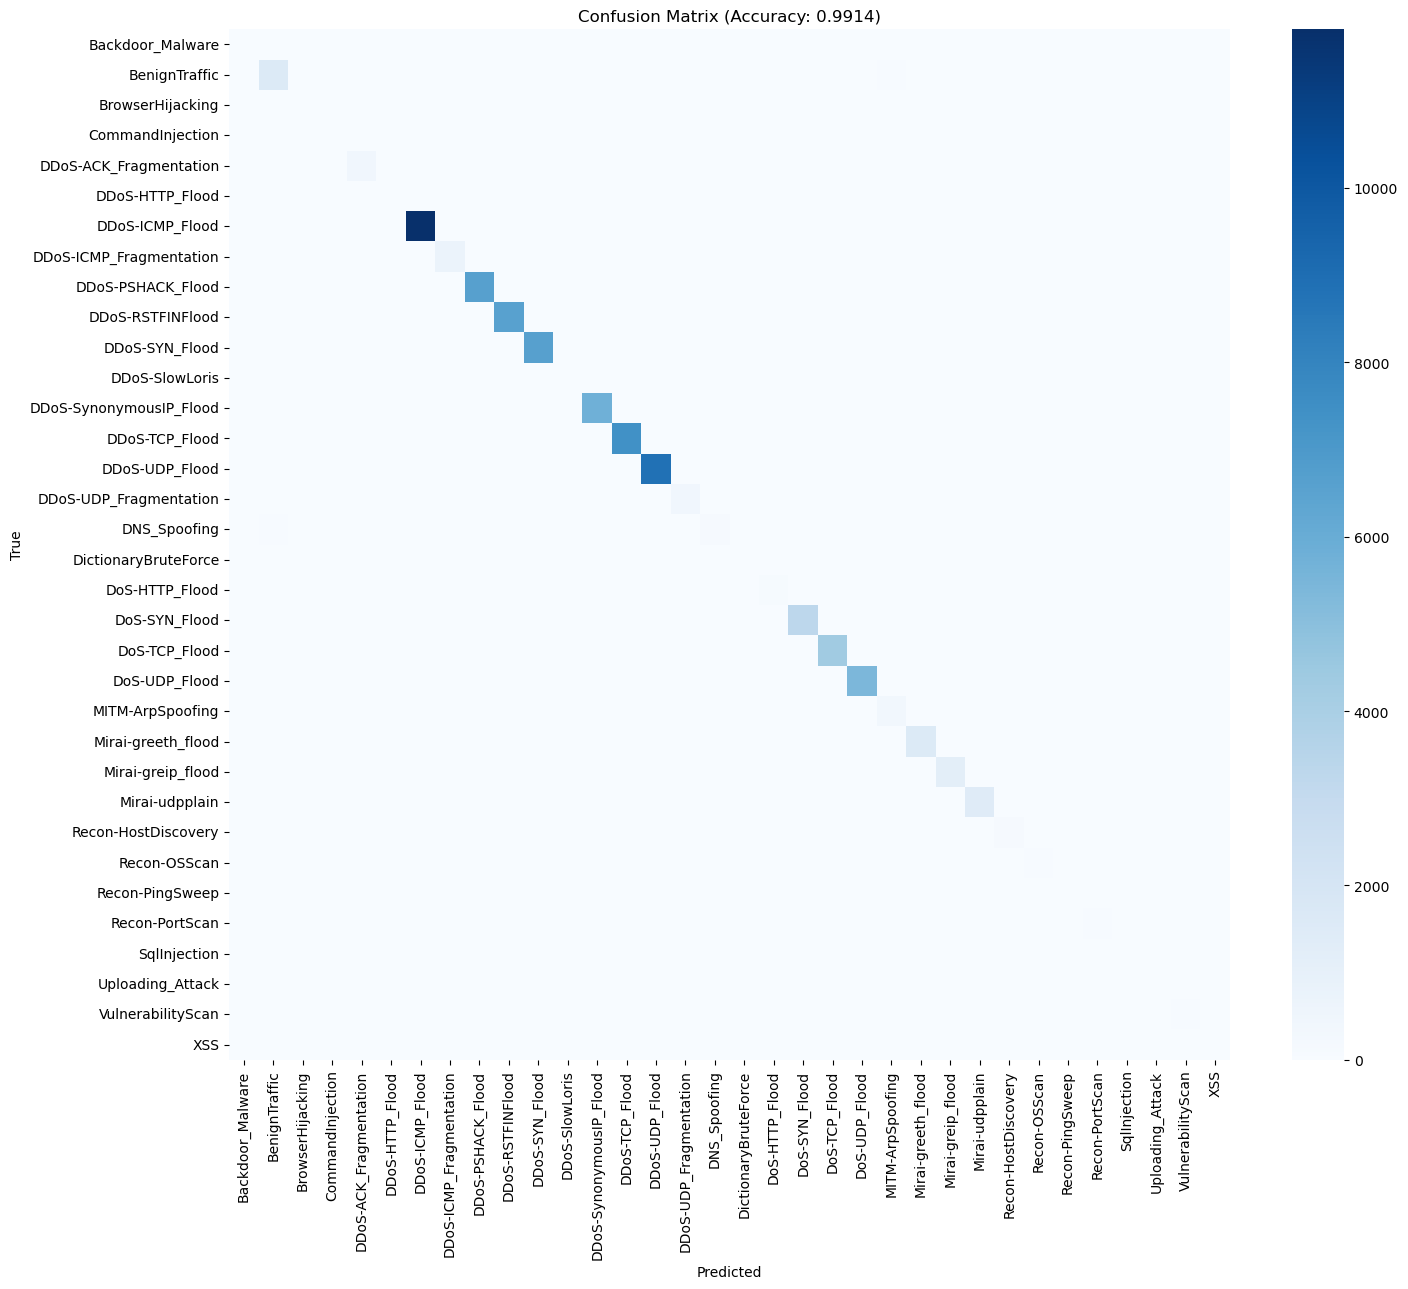

In [5]:
# --------------------------
# 3. Optimized Hybrid Model
# --------------------------

# Faster base models with good accuracy
rf = RandomForestClassifier(
    n_estimators=150,  # Reduced trees
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=150,  # Reduced trees
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=len(np.unique(y_balanced_mc)),
    random_state=42,
    tree_method='hist'
)

# Optimized stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf),
        ('xgboost', xgb)
    ],
    final_estimator=LogisticRegression(
        C=0.1,
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        multi_class='multinomial',
        random_state=42
    ),
    cv=3,  # Reduced CV folds
    n_jobs=-1
)

# Train model (FIXED: use multiclass variables)
print("\nTraining optimized hybrid model...")
stacking_model.fit(X_train_selected, y_balanced_mc)  # Corrected variables

# Final evaluation (FIXED: use multiclass variables)
y_pred = stacking_model.predict(X_test_selected)
final_accuracy = accuracy_score(y_test_mc, y_pred)  # Corrected variables

print("\n" + "="*50)
print(f"Final Accuracy: {final_accuracy:.6f}")
print("="*50)
print("Classification Report:")
print(classification_report(y_test_mc, y_pred, zero_division=0))  # Corrected variables

# --------------------------
# 4. Visualization
# --------------------------

# Confusion Matrix (FIXED: use correct variables)
cm = confusion_matrix(y_test_mc, y_pred)  # Corrected variables
plt.figure(figsize=(15, 13))
sns.heatmap(cm, annot=False, cmap='Blues', 
            xticklabels=le_multiclass.classes_,
            yticklabels=le_multiclass.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {final_accuracy:.4f})')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

class DataPreprocessor(BaseEstimator, TransformerMixin):
    """Custom preprocessor for CICIOT2023 dataset"""
    
    def __init__(self, missing_threshold=0.3):
        self.missing_threshold = missing_threshold
        self.columns_to_drop = []
        self.imputer = SimpleImputer(strategy='median')
        self.feature_names = None
        
    def fit(self, X, y=None):
        # Identify columns with too many missing values
        missing_pct = X.isnull().sum() / len(X)
        self.columns_to_drop = missing_pct[missing_pct > self.missing_threshold].index.tolist()
        
        # Fit imputer on remaining columns
        X_filtered = X.drop(columns=self.columns_to_drop)
        
        # Remove non-numeric columns
        numeric_cols = X_filtered.select_dtypes(include=[np.number]).columns
        X_numeric = X_filtered[numeric_cols]
        
        # Handle infinite values
        X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan)
        
        self.imputer.fit(X_numeric)
        self.feature_names = X_numeric.columns.tolist()
        
        return self
    
    def transform(self, X):
        # Apply same filtering as in fit
        X_filtered = X.drop(columns=self.columns_to_drop, errors='ignore')
        
        # Keep only numeric columns that were in training
        X_numeric = X_filtered.reindex(columns=self.feature_names, fill_value=0)
        
        # Handle infinite values
        X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan)
        
        # Apply imputation
        X_imputed = pd.DataFrame(
            self.imputer.transform(X_numeric),
            columns=self.feature_names,
            index=X_numeric.index
        )
        
        return X_imputed

class AdvancedFeatureSelector(BaseEstimator, TransformerMixin):
    """Advanced feature selection combining multiple methods"""
    
    def __init__(self, n_features=50, selection_method='hybrid'):
        self.n_features = n_features
        self.selection_method = selection_method
        self.selected_features = None
        self.feature_scores = None
        
    def fit(self, X, y):
        if self.selection_method == 'mutual_info':
            # Mutual Information
            mi_scores = mutual_info_classif(X, y, random_state=42)
            top_features = np.argsort(mi_scores)[-self.n_features:]
            
        elif self.selection_method == 'rfe':
            # Recursive Feature Elimination
            estimator = RandomForestClassifier(n_estimators=100, random_state=42)
            rfe = RFE(estimator, n_features_to_select=self.n_features)
            rfe.fit(X, y)
            top_features = np.where(rfe.support_)[0]
            
        elif self.selection_method == 'hybrid':
            # Hybrid approach: MI + RF importance + Statistical tests
            
            # 1. Mutual Information
            mi_scores = mutual_info_classif(X, y, random_state=42)
            mi_scores = mi_scores / np.max(mi_scores)  # Normalize
            
            # 2. Random Forest Importance
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X, y)
            rf_scores = rf.feature_importances_
            rf_scores = rf_scores / np.max(rf_scores)  # Normalize
            
            # 3. Variance-based selection (remove low variance features)
            var_scores = np.var(X, axis=0)
            var_scores = var_scores / np.max(var_scores)  # Normalize
            
            # 4. Correlation-based selection (remove highly correlated features)
            corr_matrix = np.corrcoef(X.T)
            corr_scores = 1 - np.max(np.abs(corr_matrix - np.eye(len(corr_matrix))), axis=0)
            corr_scores = corr_scores / np.max(corr_scores)  # Normalize
            
            # Combine scores
            combined_scores = (0.4 * mi_scores + 0.3 * rf_scores + 
                             0.2 * var_scores + 0.1 * corr_scores)
            
            top_features = np.argsort(combined_scores)[-self.n_features:]
            self.feature_scores = combined_scores
            
        self.selected_features = top_features
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.iloc[:, self.selected_features]
        return X[:, self.selected_features]
    
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [input_features[i] for i in self.selected_features]
        return [f'feature_{i}' for i in self.selected_features]

class CICIOTClassificationPipeline:
    """Complete pipeline for CICIOT2023 dataset classification"""
    
    def __init__(self, dataset_path, test_size=0.2, random_state=42):
        self.dataset_path = dataset_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.binary_pipeline = None
        self.multiclass_pipeline = None
        self.binary_results = {}
        self.multiclass_results = {}
        
    def load_data(self):
        """Load and perform initial data exploration"""
        print("Loading CICIOT2023 dataset...")
        self.data = pd.read_csv(self.dataset_path)
        
        print(f"Dataset shape: {self.data.shape}")
        print(f"Missing values: {self.data.isnull().sum().sum()}")
        print(f"Duplicate rows: {self.data.duplicated().sum()}")
        
        # Display class distribution
        if 'label' in self.data.columns:
            print("\nClass distribution:")
            print(self.data['label'].value_counts())
        
        return self.data
    
    def create_binary_pipeline(self, n_features=50):
        """Create optimized binary classification pipeline"""
        
        # Define base models with optimized hyperparameters
        rf = RandomForestClassifier(
            n_estimators=500,
            max_depth=20,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight='balanced',
            random_state=self.random_state,
            n_jobs=-1
        )
        
        xgb = XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=self.random_state,
            tree_method='hist'
        )
        
        lgb = LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            class_weight='balanced',
            random_state=self.random_state,
            verbose=-1
        )
        
        # Stacking ensemble
        stacking_clf = StackingClassifier(
            estimators=[
                ('rf', rf),
                ('xgb', xgb),
                ('lgb', lgb)
            ],
            final_estimator=LogisticRegression(
                C=0.1,
                solver='liblinear',
                max_iter=1000,
                class_weight='balanced',
                random_state=self.random_state
            ),
            cv=5,
            n_jobs=-1,
            passthrough=True
        )
        
        # Complete pipeline
        self.binary_pipeline = ImbPipeline([
            ('preprocessor', DataPreprocessor(missing_threshold=0.3)),
            ('scaler', RobustScaler()),
            ('feature_selector', AdvancedFeatureSelector(n_features=n_features, selection_method='hybrid')),
            ('smote', SMOTE(random_state=self.random_state, k_neighbors=5)),
            ('classifier', stacking_clf)
        ])
        
        return self.binary_pipeline
    
    def create_multiclass_pipeline(self, n_features=60):
        """Create optimized multiclass classification pipeline"""
        
        # Define base models optimized for multiclass
        rf = RandomForestClassifier(
            n_estimators=500,
            max_depth=25,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight='balanced',
            random_state=self.random_state,
            n_jobs=-1
        )
        
        xgb = XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=0.1,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=self.random_state,
            tree_method='hist'
        )
        
        lgb = LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            class_weight='balanced',
            random_state=self.random_state,
            verbose=-1
        )
        
        # Stacking ensemble
        stacking_clf = StackingClassifier(
            estimators=[
                ('rf', rf),
                ('xgb', xgb),
                ('lgb', lgb)
            ],
            final_estimator=LogisticRegression(
                C=0.1,
                solver='lbfgs',
                max_iter=1000,
                class_weight='balanced',
                multi_class='multinomial',
                random_state=self.random_state
            ),
            cv=5,
            n_jobs=-1,
            passthrough=True
        )
        
        # Complete pipeline
        self.multiclass_pipeline = ImbPipeline([
            ('preprocessor', DataPreprocessor(missing_threshold=0.3)),
            ('scaler', RobustScaler()),
            ('feature_selector', AdvancedFeatureSelector(n_features=n_features, selection_method='hybrid')),
            ('smote', SMOTE(random_state=self.random_state, k_neighbors=3)),
            ('classifier', stacking_clf)
        ])
        
        return self.multiclass_pipeline
    
    def prepare_binary_labels(self, y):
        """Convert multiclass labels to binary (normal vs attack)"""
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # Find benign/normal class
        benign_keywords = ['benign', 'normal', 'legitimate', 'benigntraffic']
        benign_indices = [i for i, cls in enumerate(le.classes_) 
                         if any(kw in cls.lower() for kw in benign_keywords)]
        
        if benign_indices:
            benign_index = benign_indices[0]
            y_binary = np.where(y_encoded == benign_index, 0, 1)
        else:
            # If no clear benign class, use class distribution
            unique, counts = np.unique(y_encoded, return_counts=True)
            most_frequent_class = unique[np.argmax(counts)]
            y_binary = np.where(y_encoded == most_frequent_class, 0, 1)
        
        return y_binary
    
    def train_binary_classifier(self, optimize_hyperparams=True):
        """Train binary classification model"""
        print("\n" + "="*60)
        print("BINARY CLASSIFICATION TRAINING")
        print("="*60)
        
        # Prepare data
        X = self.data.drop('label', axis=1)
        y = self.data['label']
        y_binary = self.prepare_binary_labels(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binary, test_size=self.test_size, 
            stratify=y_binary, random_state=self.random_state
        )
        
        # Create and train pipeline
        if self.binary_pipeline is None:
            self.create_binary_pipeline()
        
        print("Training binary classification pipeline...")
        self.binary_pipeline.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.binary_pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        self.binary_results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'y_test': y_test,
            'y_pred': y_pred,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        print(f"Binary Classification Accuracy: {accuracy:.6f}")
        print(f"Binary Classification F1-Score: {f1:.6f}")
        
        return self.binary_results
    
    def train_multiclass_classifier(self, optimize_hyperparams=True):
        """Train multiclass classification model"""
        print("\n" + "="*60)
        print("MULTICLASS CLASSIFICATION TRAINING")
        print("="*60)
        
        # Prepare data
        X = self.data.drop('label', axis=1)
        y = self.data['label']
        
        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=self.test_size,
            stratify=y_encoded, random_state=self.random_state
        )
        
        # Create and train pipeline
        if self.multiclass_pipeline is None:
            self.create_multiclass_pipeline()
        
        print("Training multiclass classification pipeline...")
        self.multiclass_pipeline.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.multiclass_pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        self.multiclass_results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'y_test': y_test,
            'y_pred': y_pred,
            'label_encoder': le,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        print(f"Multiclass Classification Accuracy: {accuracy:.6f}")
        print(f"Multiclass Classification F1-Score: {f1:.6f}")
        
        return self.multiclass_results
    
    def visualize_results(self):
        """Create comprehensive visualizations"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Binary confusion matrix
        if self.binary_results:
            cm_binary = confusion_matrix(self.binary_results['y_test'], 
                                       self.binary_results['y_pred'])
            sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Normal', 'Attack'],
                       yticklabels=['Normal', 'Attack'], ax=axes[0,0])
            axes[0,0].set_title(f'Binary Classification\nAccuracy: {self.binary_results["accuracy"]:.4f}')
            axes[0,0].set_xlabel('Predicted')
            axes[0,0].set_ylabel('True')
        
        # Multiclass confusion matrix
        if self.multiclass_results:
            cm_multi = confusion_matrix(self.multiclass_results['y_test'], 
                                      self.multiclass_results['y_pred'])
            sns.heatmap(cm_multi, annot=False, cmap='Blues', ax=axes[0,1])
            axes[0,1].set_title(f'Multiclass Classification\nAccuracy: {self.multiclass_results["accuracy"]:.4f}')
            axes[0,1].set_xlabel('Predicted')
            axes[0,1].set_ylabel('True')
        
        # Feature importance (if available)
        if self.binary_pipeline is not None:
            feature_selector = self.binary_pipeline.named_steps['feature_selector']
            if hasattr(feature_selector, 'feature_scores') and feature_selector.feature_scores is not None:
                top_features = np.argsort(feature_selector.feature_scores)[-20:]
                axes[1,0].barh(range(len(top_features)), 
                              feature_selector.feature_scores[top_features])
                axes[1,0].set_title('Top 20 Features (Binary)')
                axes[1,0].set_xlabel('Feature Importance')
        
        # Accuracy comparison
        accuracies = []
        labels = []
        if self.binary_results:
            accuracies.append(self.binary_results['accuracy'])
            labels.append('Binary')
        if self.multiclass_results:
            accuracies.append(self.multiclass_results['accuracy'])
            labels.append('Multiclass')
        
        if accuracies:
            axes[1,1].bar(labels, accuracies, color=['blue', 'green'])
            axes[1,1].set_title('Classification Accuracy Comparison')
            axes[1,1].set_ylabel('Accuracy')
            axes[1,1].set_ylim(0, 1)
            
            # Add value labels on bars
            for i, v in enumerate(accuracies):
                axes[1,1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def detect_vulnerabilities(self):
        """Analyze potential vulnerabilities and data quality issues"""
        print("\n" + "="*60)
        print("VULNERABILITY DETECTION & DATA QUALITY ANALYSIS")
        print("="*60)
        
        vulnerabilities = []
        
        # 1. Data imbalance analysis
        if 'label' in self.data.columns:
            class_counts = self.data['label'].value_counts()
            imbalance_ratio = class_counts.max() / class_counts.min()
            if imbalance_ratio > 10:
                vulnerabilities.append(f"Severe class imbalance detected (ratio: {imbalance_ratio:.2f})")
        
        # 2. Missing data analysis
        missing_pct = self.data.isnull().sum() / len(self.data) * 100
        high_missing = missing_pct[missing_pct > 50]
        if not high_missing.empty:
            vulnerabilities.append(f"Features with >50% missing data: {len(high_missing)}")
        
        # 3. Duplicate detection
        duplicate_pct = self.data.duplicated().sum() / len(self.data) * 100
        if duplicate_pct > 10:
            vulnerabilities.append(f"High duplicate rate: {duplicate_pct:.2f}%")
        
        # 4. Outlier detection
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        outlier_counts = {}
        for col in numeric_cols[:10]:  # Check first 10 numeric columns
            Q1 = self.data[col].quantile(0.25)
            Q3 = self.data[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((self.data[col] < (Q1 - 1.5 * IQR)) | 
                       (self.data[col] > (Q3 + 1.5 * IQR))).sum()
            outlier_counts[col] = outliers
        
        high_outlier_cols = [col for col, count in outlier_counts.items() 
                           if count > len(self.data) * 0.1]
        if high_outlier_cols:
            vulnerabilities.append(f"Features with >10% outliers: {len(high_outlier_cols)}")
        
        # 5. Feature correlation analysis
        if len(numeric_cols) > 1:
            corr_matrix = self.data[numeric_cols].corr()
            high_corr_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.95:
                        high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
            
            if high_corr_pairs:
                vulnerabilities.append(f"Highly correlated feature pairs: {len(high_corr_pairs)}")
        
        # Print vulnerabilities
        if vulnerabilities:
            print("⚠️  DETECTED VULNERABILITIES:")
            for i, vuln in enumerate(vulnerabilities, 1):
                print(f"  {i}. {vuln}")
        else:
            print("✅ No major vulnerabilities detected")
        
        return vulnerabilities
    
    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("="*60)
        print("CICIOT2023 CLASSIFICATION ANALYSIS")
        print("="*60)
        
        # Load data
        self.load_data()
        
        # Detect vulnerabilities
        self.detect_vulnerabilities()
        
        # Train models
        self.train_binary_classifier()
        self.train_multiclass_classifier()
        
        # Visualize results
        self.visualize_results()
        
        # Print summary
        print("\n" + "="*60)
        print("FINAL RESULTS SUMMARY")
        print("="*60)
        print(f"Binary Classification Accuracy: {self.binary_results['accuracy']:.6f}")
        print(f"Binary Classification F1-Score: {self.binary_results['f1_score']:.6f}")
        print(f"Multiclass Classification Accuracy: {self.multiclass_results['accuracy']:.6f}")
        print(f"Multiclass Classification F1-Score: {self.multiclass_results['f1_score']:.6f}")
        
        return self.binary_results, self.multiclass_results

# Usage example
if __name__ == "__main__":
    # Initialize pipeline
    pipeline = CICIOTClassificationPipeline(
        dataset_path='C:\\ProgramData\\anaconda3\\Lib\\site-packages\\pandas\\io\\parsers\\capstone\\part-00112-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv',  # Replace with your dataset path
        test_size=0.2,
        random_state=42
    )
    
    # Run complete analysis
    binary_results, multiclass_results = pipeline.run_complete_analysis()

CICIOT2023 CLASSIFICATION ANALYSIS
Loading CICIOT2023 dataset...
Dataset shape: (253575, 47)
Missing values: 0
Duplicate rows: 0

Class distribution:
label
DDoS-ICMP_Flood            39408
DDoS-UDP_Flood             29523
DDoS-TCP_Flood             24764
DDoS-PSHACK_Flood          22151
DDoS-SYN_Flood             22058
DDoS-RSTFINFlood           22004
DDoS-SynonymousIP_Flood    19265
DoS-UDP_Flood              18023
DoS-TCP_Flood              14319
DoS-SYN_Flood              11074
BenignTraffic               5882
Mirai-greeth_flood          5301
Mirai-udpplain              4797
Mirai-greip_flood           4123
DDoS-ICMP_Fragmentation     2440
MITM-ArpSpoofing            1713
DDoS-ACK_Fragmentation      1534
DDoS-UDP_Fragmentation      1493
DNS_Spoofing                 972
Recon-HostDiscovery          717
Recon-OSScan                 507
Recon-PortScan               425
DoS-HTTP_Flood               401
VulnerabilityScan            200
DDoS-HTTP_Flood              133
DDoS-SlowLoris     